In [ ]:
# Exploratory Data Analysis for BankSim Fraud Detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/banksim.csv")

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# Convert isFraud from 0/1 to 'Legit' / 'Fraud'
df['isFraud'] = df['isFraud'].map({0: "Legit", 1: "Fraud"}).astype("category")

# Quick check: proportion of fraud
fraud_rate = (df['isFraud'] == "Fraud").mean() * 100
fraud_rate

0.12908204481801522

In [3]:
# Randomly make 500 values in oldbalanceOrg missing
np.random.seed(123)  # reproducibility
idx = np.random.choice(df.index, size=500, replace=False)
df.loc[idx, 'oldbalanceOrg'] = np.nan

# Check missingness
df['oldbalanceOrg'].isna().sum()

500

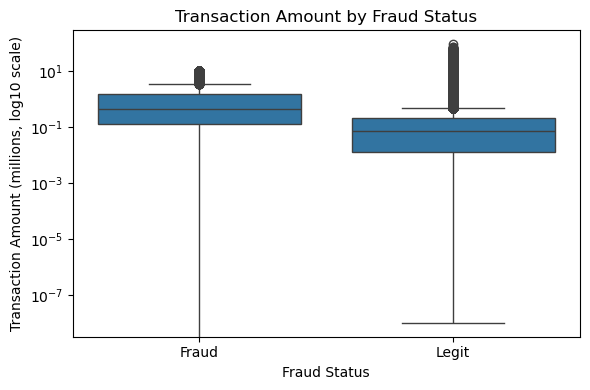

In [ ]:
# Figure 1: Distribution of 'amount' feature (log10 scale)
# Create amount in millions for readability
df['amount_millions'] = df['amount'] / 1_000_000

# Boxplot: transaction amount (millions) by fraud status, log10 scale
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="isFraud", y="amount_millions")
plt.yscale("log")
plt.title("Transaction Amount by Fraud Status")
plt.xlabel("Fraud Status")
plt.ylabel("Transaction Amount (millions, log10 scale)")
plt.tight_layout()
plt.show()

In [ ]:
# Figure 2: transaction type vs fraud (stacked bar + counts)
# Count transactions by type and fraud status
counts = (
    df.groupby(['type', 'isFraud'])
      .size()
      .reset_index(name='n')
)

counts.head()

/var/folders/2d/489p90hj1z39jt0zq_dfbhh40000gn/T/ipykernel_26985/2576005294.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['type', 'isFraud'])


,type,isFraud,n
0,CASH_IN,Fraud,0
1,CASH_IN,Legit,1399284
2,CASH_OUT,Fraud,4116
3,CASH_OUT,Legit,2233384
4,DEBIT,Fraud,0


/var/folders/2d/489p90hj1z39jt0zq_dfbhh40000gn/T/ipykernel_26985/3545131324.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


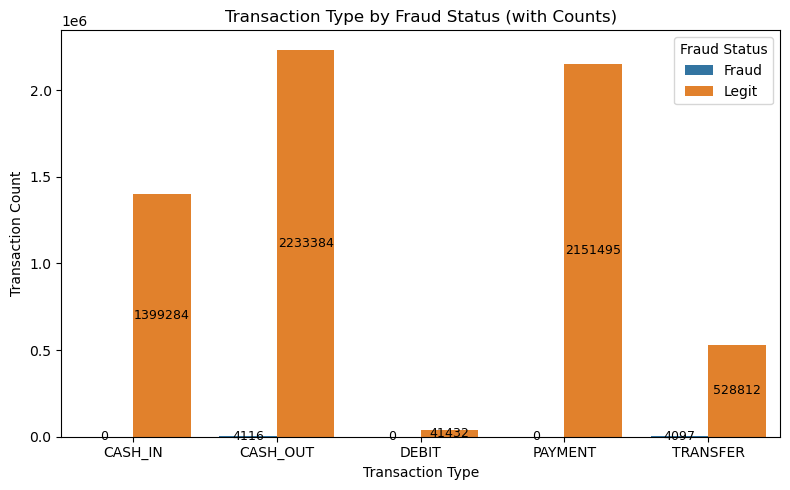

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=counts,
    x="type",
    y="n",
    hue="isFraud",
    estimator=sum,
    ci=None
)

plt.title("Transaction Type by Fraud Status (with Counts)")
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Count")

# Annotate stacked bars with counts
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=9, color="black")

plt.legend(title="Fraud Status")
plt.tight_layout()
plt.show()

Summary tables (more wrangling)

In [7]:
# Table: summary of amount (millions) by fraud status
amount_summary = (
    df.groupby('isFraud')['amount_millions']
      .agg(['count', 'median', 'mean', 'min', 'max'])
      .round(3)
)
amount_summary

/var/folders/2d/489p90hj1z39jt0zq_dfbhh40000gn/T/ipykernel_26985/2680673125.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('isFraud')['amount_millions']


,count,median,mean,min,max
isFraud,,,,,
Fraud,8213,0.441,1.468,0.0,10.000
Legit,6354407,0.075,0.178,0.0,92.446


In [8]:
# Table: fraud rate by transaction type
fraud_by_type = (
    df.groupby('type')['isFraud']
      .value_counts(normalize=True)
      .rename('proportion')
      .mul(100)
      .reset_index()
      .pivot(index='type', columns='isFraud', values='proportion')
      .round(3)
)
fraud_by_type

isFraud,Fraud,Legit
type,,
CASH_IN,0.000,100.000
CASH_OUT,0.184,99.816
DEBIT,0.000,100.000
PAYMENT,0.000,100.000
TRANSFER,0.769,99.231


In [ ]:
# Multiple imputation (Python analogue of mice)
# Impute missing values in oldbalanceOrg using IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

imp_data = df[['amount', 'oldbalanceOrg', 'newbalanceOrig']]

imputer = IterativeImputer(random_state=500)
imp_array = imputer.fit_transform(imp_data)

imp_df = pd.DataFrame(imp_array, columns=imp_data.columns)

# Replace imputed oldbalanceOrg back into main df
df['oldbalanceOrg'] = imp_df['oldbalanceOrg']
df['oldbalanceOrg'].isna().sum()

0

In [ ]:
# Summary: imputation results
# Compare distributions before vs after imputation (for oldbalanceOrg)
before = imp_data['oldbalanceOrg']
after = df['oldbalanceOrg']

summary_imputation = pd.DataFrame({
    "metric": ["mean", "std", "min", "25%", "50%", "75%", "max"],
    "before": [
        before.mean(), before.std(), before.min(),
        before.quantile(0.25), before.median(),
        before.quantile(0.75), before.max()
    ],
    "after": [
        after.mean(), after.std(), after.min(),
        after.quantile(0.25), after.median(),
        after.quantile(0.75), after.max()
    ]
}).round(3)

summary_imputation

,metric,before,after
0,mean,8.338922e+05,8.338830e+05
1,std,2.888266e+06,2.888243e+06
2,min,0.000000e+00,-1.415886e+04
3,25%,0.000000e+00,0.000000e+00
4,50%,1.420800e+04,1.420555e+04
5,75%,1.073160e+05,1.073160e+05
6,max,5.958504e+07,5.958504e+07


In [11]:
# save the processed data for the modelling notebook:
df.to_csv("../data/banksim_clean_imputed.csv", index=False)